In [8]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# enable use of local modules
repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
from mejiro.utils import util

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# set HWO directory
hwo_dir = os.path.join(repo_dir, 'papers', 'hwo')

In [9]:
logm_low = 4
logm_high = 10

In [10]:
def get_detectable_subhalo_params(detectable_subhalos):
    """
    Returns the redshift, mass, and concentration of detectable subhalos
    """    
    z_list, m_list, c_list = [], [], []
    for halo_list in detectable_subhalos:
        for z, m, c in halo_list:
            z_list.append(z)
            m_list.append(m)
            c_list.append(c)
    return z_list, m_list, c_list

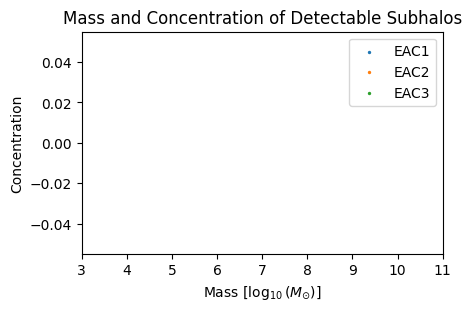

In [11]:
data_dir = '/data/bwedig/mejiro'

eac1_detectable_subhalos = util.unpickle_all(os.path.join(data_dir, 'hwo_subhalo_detection_compare_eac1'), 'detectable_halos_', '.pkl')
eac2_detectable_subhalos = util.unpickle_all(os.path.join(data_dir, 'hwo_subhalo_detection_compare_eac2'), 'detectable_halos_', '.pkl')
eac3_detectable_subhalos = util.unpickle_all(os.path.join(data_dir, 'hwo_subhalo_detection_compare_eac3'), 'detectable_halos_', '.pkl')

eac1_z_list, eac1_m_list, eac1_c_list = get_detectable_subhalo_params(eac1_detectable_subhalos)
eac2_z_list, eac2_m_list, eac2_c_list = get_detectable_subhalo_params(eac2_detectable_subhalos)
eac3_z_list, eac3_m_list, eac3_c_list = get_detectable_subhalo_params(eac3_detectable_subhalos)

plt.figure(figsize=(4.5, 3), constrained_layout=True)
plt.scatter(np.log10(eac1_m_list), eac1_c_list, s=2, label='EAC1', color='C0')
plt.scatter(np.log10(eac2_m_list), eac2_c_list, s=2, label='EAC2', color='C1')
plt.scatter(np.log10(eac3_m_list), eac3_c_list, s=2, label='EAC3', color='C2')
plt.xlabel(r'Mass [$\log_{10}(M_{\odot})$]')
plt.ylabel('Concentration')
plt.xlim(logm_low - 1, logm_high + 1)
plt.legend()
plt.title('Mass and Concentration of Detectable Subhalos')
plt.savefig(os.path.join(hwo_dir, 'figures', 'detectable_subhalos.png'))
plt.show()

In [12]:
def get_percent_detectable(m_list, detectable_halos):
    percent_det = []
    mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, 100)]
    m_list = [np.log10(m) for m in m_list]

    for m in mlog10_list:
        count = np.sum(np.array(m_list) == m)
        percent_det.append(count / len(detectable_halos))

    return percent_det

/tmp/ipykernel_1510035/2597413828.py:8: RuntimeWarning: invalid value encountered in scalar divide
  percent_det.append(count / len(detectable_halos))


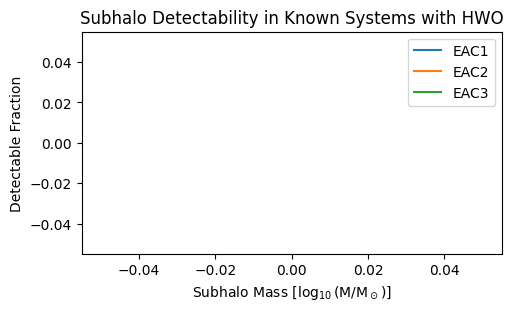

In [13]:
mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, 100)]

plt.figure(figsize=(5, 3), constrained_layout=True)
plt.plot(mlog10_list, get_percent_detectable(eac1_m_list, eac1_detectable_subhalos), color='C0', label='EAC1')
plt.plot(mlog10_list, get_percent_detectable(eac2_m_list, eac2_detectable_subhalos), color='C1', label='EAC2')
plt.plot(mlog10_list, get_percent_detectable(eac3_m_list, eac3_detectable_subhalos), color='C2', label='EAC3')
plt.legend()
plt.ylabel('Detectable Fraction')
plt.xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
plt.title('Subhalo Detectability in Known Systems with HWO')
plt.savefig(os.path.join(hwo_dir, 'figures', 'subhalo_detection_compare.png'))
plt.show()